In [1]:
import os
from collections import OrderedDict
import logging

import numpy as np
from astropy.table import Table

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.DEBUG)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.DEBUG)


In [2]:
# Load the data
data = np.load("/Users/fred/projects/deblender/data/test1/images.npy")
mask = np.load("/Users/fred/projects/deblender/data/test1/mask.npy")
variance = np.load("/Users/fred/projects/deblender/data/test1/variance.npy")
psfs = np.load("/Users/fred/projects/deblender/data/test1/psfs.npy")
simTable= Table.read("/Users/fred/projects/deblender/data/test1/sim.fits")
all_peaks = np.load("/Users/fred/projects/deblender/data/test1/peaks.npy")
bboxes = np.load("/Users/fred/projects/deblender/data/test1/bboxes.npy")

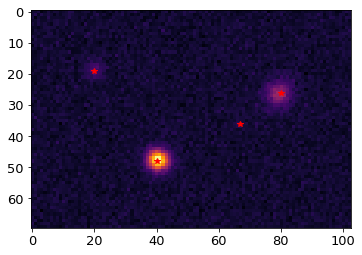

In [3]:
#parents = [len(peaks)>1 for peaks in all_peaks]
parents = [len(peaks)==4 for peaks in all_peaks]
bbox = bboxes[parents][0]
peaks = np.array(list(all_peaks[parents][0]))
# get the peak positions in image coordinates
img_peaks = np.zeros_like(peaks)
img_peaks[:,0] = peaks[:,0]-bbox[2]
img_peaks[:,1] = peaks[:,1]-bbox[0]
img = data[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
weights = variance[:,bbox[0]:bbox[1], bbox[2]:bbox[3]]
plt.imshow(img[0])
plt.plot(img_peaks[:,0], img_peaks[:,1], 'r*')

INFO:deblender.operators:Total psf pixels: 65
INFO:deblender.operators:Total psf pixels: 65
INFO:deblender.operators:Total psf pixels: 65
INFO:deblender.operators:Total psf pixels: 65
INFO:deblender.operators:Total psf pixels: 65
DEBUG:deblender.nmf:Shape: (70, 103)
DEBUG:deblender.nmf:Constraint norms for S (intensity) matrix: [  97.18241509  120.08330442]
DEBUG:deblender.nmf:prox_g: [<function prox_unity_plus at 0x10ef6b268>, [functools.partial(<function prox_min at 0x10ef6b048>, l=0), <function prox_zero at 0x10ef64e18>]]
DEBUG:deblender.nmf:all_step_g: None
DEBUG:deblender.nmf:all_constraints: [None, [<7210x7210 sparse matrix of type '<class 'numpy.float64'>'
	with 35395 stored elements in COOrdinate format>, <7210x7210 sparse matrix of type '<class 'numpy.float64'>'
	with 14420 stored elements in Compressed Sparse Row format>]]
INFO:proxmin.algorithms:Completed 500 iterations


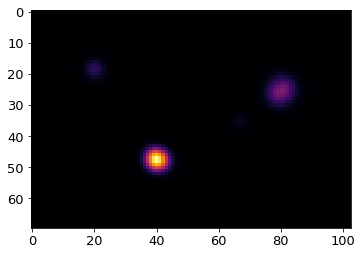

In [4]:
result = deblender.nmf.deblend(img, peaks=img_peaks, constraints="MS", weights=weights, psf=psfs, max_iter=500,
            e_rel=[1e-6,1e-3], psf_thresh=3e-3, l0_thresh=.005,
            algorithm="GLMM", traceback=False, convergence_func=None, als_max_iter=20,
            monotonicUseNearest=False)
A, S, model, P_, Tx, Ty, errors = result

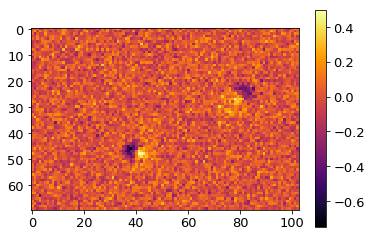

In [5]:
plt.imshow(img[0]-model[0])
plt.colorbar()
plt.show()

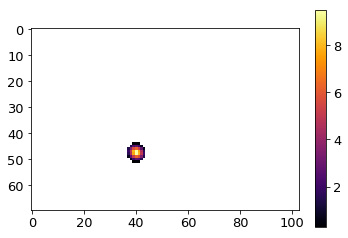

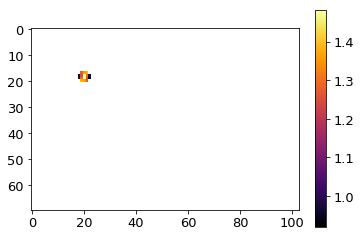

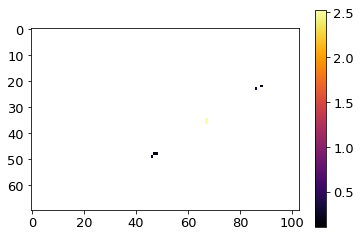

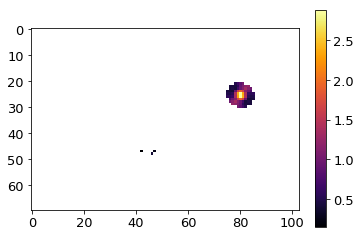

In [6]:
for k in range(len(S)):
    model = deblender.nmf.get_peak_model(A[:,k], S[k].flatten(), Tx[k], Ty[k], shape=(S[k].shape))[0]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()

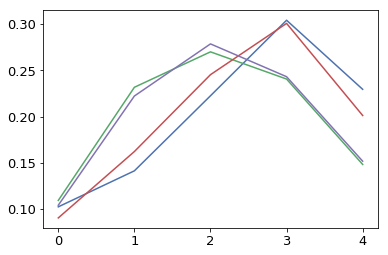

In [7]:
for k in range(A.shape[1]):
    plt.plot(A[:,k])
plt.show()

DEBUG:deblender.nmf:Shape: (70, 103)
DEBUG:deblender.nmf:Constraint norms for S (intensity) matrix: [  97.18241509  120.08330442]
DEBUG:deblender.nmf:prox_g: [[<function prox_unity_plus at 0x1174ec268>], [functools.partial(<function prox_min at 0x1174ec048>, l=0), <function prox_zero at 0x1174e5e18>]]
DEBUG:deblender.nmf:all_step_g: None
DEBUG:deblender.nmf:all_constraints: [None, [<7210x7210 sparse matrix of type '<class 'numpy.float64'>'
	with 35395 stored elements in COOrdinate format>, <7210x7210 sparse matrix of type '<class 'numpy.float64'>'
	with 14420 stored elements in Compressed Sparse Row format>]]
DEBUG:proxmin.algorithms:all_constraints: [None, [<7210x7210 sparse matrix of type '<class 'numpy.float64'>'
	with 35395 stored elements in COOrdinate format>, <7210x7210 sparse matrix of type '<class 'numpy.float64'>'
	with 14420 stored elements in Compressed Sparse Row format>]]
INFO:proxmin.algorithms:0: convergence: [False, False], iterations: [   0.  199.]
INFO:proxmin.algori

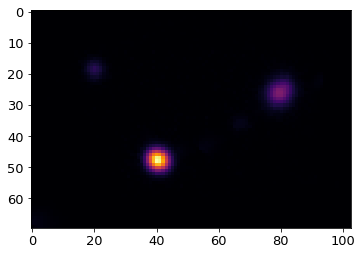

In [5]:
result = deblender.nmf.deblend(img, peaks=img_peaks, constraints="MS", weights=weights, psf=None, max_iter=200,
            e_rel=[1e-6,1e-3], psf_thresh=3e-3,
            algorithm=None, traceback=False, convergence_func=None, als_max_iter=20,
            monotonicUseNearest=False)
A, S, model, P_, Tx, Ty, errors = result

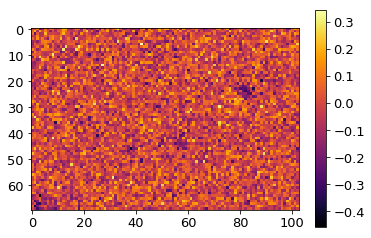

In [7]:
plt.imshow(img[0]-model[0])
plt.colorbar()
plt.show()

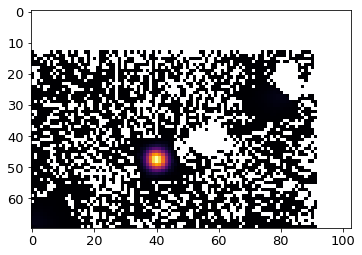

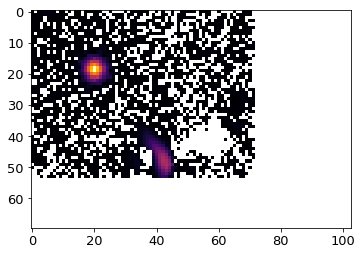

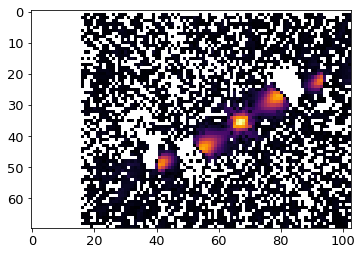

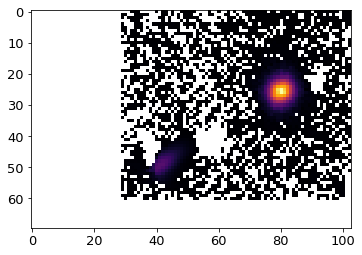

In [8]:
for k in range(len(S)):
    model = deblender.nmf.get_peak_model(A[:,k], S[k].flatten(), Tx[k], Ty[k], shape=(S[k].shape))[0]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.show()

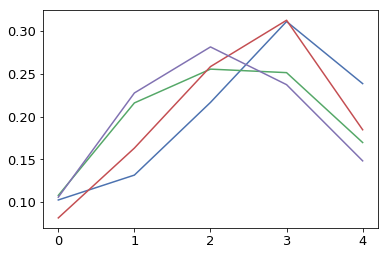

In [9]:
for k in range(A.shape[1]):
    plt.plot(A[:,k])
plt.show()